In [117]:
import c3d
import mat4py
import functools
import scipy.io
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import notebook
from torch.optim import Adam
from torch.utils.data import DataLoader
import tqdm
import math
#from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
device ='cpu'

import torch
from torch_geometric.data import Data
from sklearn.decomposition import PCA
from torch.autograd.functional import jacobian

In [118]:
mat = scipy.io.loadmat('C:\\Users\\Desktop\\Thesis\\HumanEval\\S1\\Mocap_Data\\Jog_1.mat')

In [256]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Apr 20 11:49:05 2006',
 '__version__': '1.0',
 '__globals__': [],
 'Markers': array([[[ 221.59651184,  343.78814697,  856.953125  ],
         [ 122.5647049 ,  118.52044678,  916.05212402],
         [ 323.14709473,  262.29598999,  691.0211792 ],
         ...,
         [   0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        ]],
 
        [[ 220.72203064,  348.77249146,  857.690979  ],
         [ 124.97068787,  123.20597076,  916.60211182],
         [ 323.64660645,  272.44403076,  692.46826172],
         ...,
         [   0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        ]],
 
        [[ 219.99052429,  354.8649292 ,  858.96362305],
         [ 127.46140289,  128.49403381,  917.2857666 ],
         [ 323.96463013,  282.6530

In [257]:
indices

[3, 7, 13, 35, 17, 18, 29, 32, 24, 22, 23, 36, 0, 19, 11, 2]

In [271]:
mat['ParameterGroup'][0][2][2][0][15][2][0][35]

array(['Left elbow'], dtype='<U10')

In [120]:
# I need to identify the relevant markers.

In [121]:
t = 0

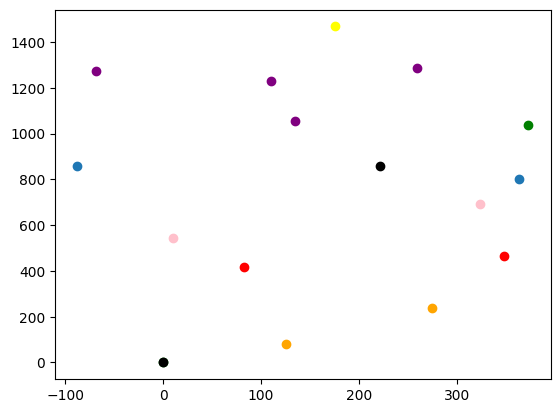

In [122]:
fig = plt.figure()
ax = fig.add_subplot()
xs= [pt[0] for pt in mat['Markers'][t]]
ys= [pt[1] for pt in mat['Markers'][t]]
zs= [pt[2] for pt in mat['Markers'][t]]
ax.scatter([xs[3],xs[7]],  [zs[3],zs[7]], label = 'Wrists')
ax.scatter([xs[13],xs[35]], [zs[13],zs[35]], label = 'Elbows', color = 'Green')
ax.scatter(xs[17:19],zs[17:19], label = 'Knees', color = 'red')
ax.scatter(xs[29:30], zs[29:30], label = 'Head', color = 'yellow')
ax.scatter([xs[32],xs[24]], [zs[32],zs[24]], label = 'Ankles', color = 'Orange')
ax.scatter(xs[22:24], zs[22:24], label = 'Shoulders', color = 'Purple')
ax.scatter([xs[36],xs[0]], [zs[36],zs[0]], label = 'ASIS', color = 'Black')
ax.scatter(xs[8],zs[8], label = 'Sternum', color = 'purple')
ax.scatter(xs[19],zs[19], label = 'Clavicle', color = 'purple')
ax.scatter([xs[11],xs[2]],[zs[11], zs[2]], label = 'Thighs', color = 'pink')

In [123]:
ds = []
for t in range(1,300):
    right_knee =mat['Markers'][t][17]
    right_asis = mat['Markers'][t][0]
    d = math.dist(right_knee,right_asis)
    ds.append(d)

In [124]:
ds_left = []
for t in range(1,300):
    left_knee =mat['Markers'][t][18]
    left_asis = mat['Markers'][t][34]
    d = math.dist(left_knee,left_asis)
    ds_left.append(d)

In [125]:
ds_left_shoulder = []
for t in range(1,300):
    left_shoulder =mat['Markers'][t][22]
    clavicle = mat['Markers'][t][19]
    d = math.dist(left_shoulder,clavicle)
    ds_left_shoulder.append(d)

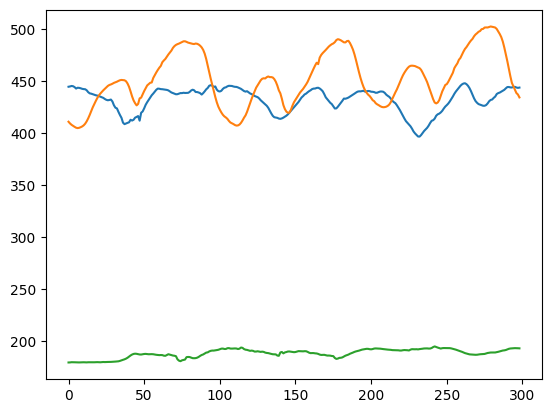

In [126]:
plt.plot(ds_left)
plt.plot(ds)
plt.plot(ds_left_shoulder)

# The Neural Network

Note - instead of a 2d image I'll input 2d matrix of 3d data... Not sure how much I should change anything...

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [128]:
class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


In [129]:
class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=16*3):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 1, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 1, stride=1, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 1, stride=1, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 1, stride=1, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 1, stride=1, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 1, stride=1, bias=False, output_padding=0)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 1, stride=1, bias=False, output_padding=0)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 1, stride=1)
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x.double())
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    print(f"size of final h1 {h1.size()}")
    h2 = self.conv2(h1)
    print(f"size of initial h2 {h2.size()}")
    h2 += self.dense2(embed)
    print(f"size of h2 after dense2 {h2.size()}")
    h2 = self.gnorm2(h2)
    print(f"size of h2 after gnorm2 {h2.size()}")
    h2 = self.act(h2)
    print(f"size of final h2 {h2.size()}")
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    print(f"This is what h WAS: {h.size(), h}")
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    print(f"This is what h is: {h.size(), h}")
    return h

In [130]:
# note - I should sort these
indices = [3,7,13,35,17,18,29,32,24,22,23,36,0,19,11,2]
dataset = []
for i in range(len(mat['Markers'])):
  data = [mat['Markers'][i][j] for j in indices]
  dataset.append(torch.tensor(np.array(data), dtype =torch.double).unsqueeze(0))

In [131]:
#ds = [torchvision.transforms.functional.to_pil_image(data) for data in dataset]

In [132]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


In [133]:
def collate_fn(batch):
    return list(batch)

In [134]:
#tensor_x = torch.stack(ds)
#dataset = TensorDataset(tensor_x) # create your datset
data_loader = DataLoader(dataset,batch_size=32,shuffle=True) # create your dataloader

In [135]:
for x in data_loader:
  print(x[0].size())
  break

torch.Size([1, 16, 3])


In [136]:
#for i in data_loader:
#  print(i[0])

In [137]:
#@title Set up the SDE

#device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [138]:
#@title Define the loss function (double click to expand or collapse)
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [139]:
#@title Training (double click to expand or collapse)
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn)).double()
#score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

#dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x in data_loader:
    x = x.to(device)
    loss = loss_fn(score_model, x.double(), marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

size of final h1 torch.Size([32, 32, 16, 3])
size of initial h2 torch.Size([32, 64, 16, 3])
size of h2 after dense2 torch.Size([32, 64, 16, 3])
size of h2 after gnorm2 torch.Size([32, 64, 16, 3])
size of final h2 torch.Size([32, 64, 16, 3])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19920\3390477272.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


This is what h WAS: (torch.Size([32, 1, 16, 3]), tensor([[[[-0.7908,  1.1671,  1.6718],
          [-1.2113, -0.6191,  2.1434],
          [-0.1430,  0.8669,  3.1900],
          ...,
          [-0.7287,  0.1883,  1.9931],
          [-0.6778, -0.5882, -0.3662],
          [-0.7386,  1.3007,  0.3918]]],


        [[[ 0.7662, -3.8820,  2.4931],
          [ 0.2005, -3.3195,  3.3180],
          [ 0.2822, -4.4188,  5.6935],
          ...,
          [ 0.4548, -3.4034,  5.5347],
          [ 0.1585, -3.4010,  0.2217],
          [ 1.0740, -3.3570,  0.7100]]],


        [[[-4.5325,  2.9393,  2.6133],
          [-2.9813,  1.0487,  2.8793],
          [-1.8282,  2.4791,  2.3149],
          ...,
          [-4.3990,  3.1098,  1.1904],
          [-3.8375,  2.3320,  1.6081],
          [-3.1043,  2.8303,  2.9911]]],


        ...,


        [[[-2.9787, -3.3124,  3.5196],
          [-3.1428, -2.7628,  3.4012],
          [-3.5482, -3.2167,  3.9847],
          ...,
          [-2.9114, -3.3258,  5.3553],
      

KeyboardInterrupt: 

In [ ]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           device='cpu',
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 16, 3, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

In [ ]:
device ='cpu'

In [ ]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 16, 3, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

In [ ]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
#device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)

## Sample visualization.
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [ ]:
mat['ParameterGroup'][0][2][2][0][15][2][0][2]

In [ ]:
indices = [3,7,13,35,17,18,29,32,24,22,23,36,0,19,11,2]
bodyparts = ['right wrist','left wrist', 'right elbow', 'left elbow', 'r knee', 'l knee', 'r front head', 'l ankle', 'r ankle', 'r shoulder', 'l shoulder','l ASIS', 'r ASIS', 'Clavicle', 'l thigh', 'r thigh']

In [ ]:
bodyparts[9]

In [ ]:
xs = [sample[0] for sample in samples[0][0]]
ys = [sample[1] for sample in samples[0][0]]
coords = [(sample[0], sample[1]) for sample in samples[0][0]]

In [ ]:
connectivity = {0: (2,0),     #coords[0] <--> coords[1], coords[2]
                1: (3,1), #coords[1] <--> coords[0], coords[2], coords[3]
                2: (0,9), #coords[2] <--> coords[0], coords[1], coords[4]
                3: (1, 10), #coords[3] <--> coords[1], coords[3], coords[5]
                4: (12, 15), #coords[4] <--> coords[2], coords[3], coords[5]
                5: (11, 14),     #coords[5] <--> coords[3], coords[4]
                6: (13,6),
                7: (14,7),
                8: (15,8),
                9: (2, 13),
                10: (3,13),
                11: (14, 13),
                12: (15,13),
                13: (9,10,11,12),
                14: (11,13),
                15: (12,13)
                }
x, y = zip(*coords)
plt.plot(x, y, 'o')  # plot the points alone
for k, v in connectivity.items():
    print(v)
    for i in v:  # plot each connections
        x, y = zip(coords[k], coords[i])
        plt.plot(x, y, 'r')
plt.show()

In [ ]:
plt.scatter(xs,ys)

In [ ]:
#

# Graph Neural Net

In [ ]:
connectivity = {0: (2,0),     #coords[0] <--> coords[1], coords[2]
                1: (3,1), #coords[1] <--> coords[0], coords[2], coords[3]
                2: (0,9), #coords[2] <--> coords[0], coords[1], coords[4]
                3: (1, 10), #coords[3] <--> coords[1], coords[3], coords[5]
                4: (12, 15), #coords[4] <--> coords[2], coords[3], coords[5]
                5: (11, 14),     #coords[5] <--> coords[3], coords[4]
                6: (13,6),
                7: (14,7),
                8: (15,8),
                9: (2, 13),
                10: (3,13),
                11: (14, 13),
                12: (15,13),
                13: (9,10,11,12),
                14: (11),
                15: (12)
                }

In [ ]:
edge_index = torch.tensor([[0, 2],
                           [2, 0],
                           [3, 1],
                           [1, 3],
                           [2,9],
                           [9,2],
                           [3,1],
                           [1,3],
                           [3,10],
                           [10,3],
                           [4,12],
                           [12,4],
                           [4,15],
                           [15,4],
                           [5,11],
                           [11,5],
                           [14,5],
                           [5,14],
                           [6,13],
                           [13,6],
                           [17,4],
                           [4,17],
                           [8,15],
                           [15,8],
                           [9,2],
                           [2,9],
                           [9,13],
                           [13,9],
                           [10,3],
                           [3,10],
                           [10,13],
                           [13,10],
                           [11,14],
                           [14,11],
                            [11,13],
                           [13,11],
                           [12,13],
                           [13,12],
                           [12,15],
                           [15,12],], dtype=torch.long)
x = torch.zeros(16)

data = Data(x=x, edge_index=edge_index.t().contiguous(), pos=dataset[0][0])

In [ ]:
# note - I should sort these
indices = [3,7,13,35,17,18,29,32,24,22,23,36,0,19,11,2]
dataset = []
for i in range(len(mat['Markers'])):
  data = [mat['Markers'][i][j] for j in indices]
  dataset.append(torch.tensor(np.array(data), dtype =torch.double).unsqueeze(0))

In [ ]:
from torch_geometric.loader import DataLoader

In [ ]:
graph_set = []
for data in dataset:
    graph =Data(x=x, edge_index=edge_index.t().contiguous(), pos=data[0])
    graph_set.append(graph)

In [ ]:
from torch.utils.data.dataloader import default_collate

In [ ]:
data_loader = DataLoader(graph_set,batch_size=32,shuffle=True, collate_fn=default_collate)

In [ ]:
for i in data_loader:
    print(i)
    break

In [ ]:
#@title Define the loss function (double click to expand or collapse)
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(len(x.batch), device='cpu') * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t,)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class PositionalGNN(nn.Module):
    def __init__(self, num_features, num_classes, embed_dim = 16*3,marginal_prob_std=marginal_prob_std_fn):
        super(PositionalGNN, self).__init__()
        self.dense1 = Dense(embed_dim, 32)
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 1)
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x,t):
        edge_index = x.edge_index
        pos = x.pos
        embed = self.act(self.embed(t))
        x = self.conv1(x, edge_index)
        x += self.dense1(embed)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        print(f"This is x {x.size()}")
        #x = F.log_softmax(x, dim=1) # change the softmax

        return x

# Example usage:

num_classes = 1  # Number of output classes

# Generate some random input data


model = PositionalGNN(num_features, num_classes)
output = model(x, edge_index, pos)

In [ ]:
#@title Training (double click to expand or collapse)
score_model = torch.nn.DataParallel(PositionalGNN(3,1))
#score_model = score_model.to(device)

n_epochs = 50  #@param {'type':'integer'}
## size of a mini-batch
batch_size = 32  #@param {'type':'integer'}
## learning rate
lr = 1e-4  #@param {'type':'number'}

#dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        x = x.to(device)
        print(x)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt.pth')

# Copying their approach

## Principal component analysis

In [ ]:
list = np.array([data[0].flatten().numpy() for data in dataset])

In [ ]:
list[0]

In [ ]:
list

In [230]:
# Create a PCA object
pca = PCA(n_components=48)  # Specify the number of components you want to retain



In [231]:
pca_result = pca.fit_transform(list)

In [232]:
len(list[0])

48

In [233]:
len(pca_result[0])

48

In [234]:
eigenposes = pca.components_
eigenvalues = pca.explained_variance_

In [235]:
len(eigenposes[0])

48

## Calculating the projections

In [236]:
# Define the distortion coefficients
dist_coeffs = np.zeros((5, 1), np.float32)


points_3d = dataset[1].numpy()

# Define the rotation and translation vectors
rvec = np.zeros((3, 1), np.float32)
tvec = np.zeros((3, 1), np.float32)

# Map the 3D point to 2D point
points_2d, _ = cv2.projectPoints(points_3d,
                                 rvec, tvec,
                                 camera_matrix,
                                 dist_coeffs)

In [237]:
xs = np.array([x[0] for x in points_2d])

In [238]:
transform = torch.zeros((16,3))
for i in range(16):
    transform[i][2] = 1000

In [239]:
ds = np.array([(d+ transform).numpy() for d in dataset])

In [240]:
np.shape(ds)

(2733, 1, 16, 3)

In [241]:
avg_pose = np.squeeze(ds.mean(axis =0))
avg_pose = np.ndarray.flatten(avg_pose)

In [242]:
torch.set_default_dtype(torch.double)

In [243]:
pose1 = torch.squeeze(dataset[0]) + transform

In [244]:
projection = torch.zeros((16,2))
fx = 1.0
fy = 1.0
cx = 0
cy = 0
a1 = torch.tensor([fx, 0, cx], dtype=torch.double)
a2 = torch.tensor([0, fy, cy], dtype=torch.double)
a3 = torch.tensor([0,0,1], dtype=torch.double)
for i in range(16):
    projection[i][0] = torch.dot(a1, pose1[i])/torch.dot(a3, pose1[i])
    projection[i][1] = torch.dot(a2, pose1[i])/torch.dot(a3, pose1[i])

#projection += torch.randn_like(projection)
image = projection


tensor([[ 0.2016,  0.1273],
        [-0.0472,  0.2117],
        [ 0.1829,  0.0563],
        [ 0.0000,  0.0000],
        [ 0.2380,  0.2466],
        [ 0.0582,  0.2589],
        [ 0.0711,  0.1247],
        [ 0.1155,  0.1578],
        [ 0.2223,  0.0793],
        [ 0.1136,  0.1249],
        [-0.0301,  0.1346],
        [ 0.0000,  0.0000],
        [ 0.1193,  0.1851],
        [ 0.0494,  0.1649],
        [ 0.0063,  0.2209],
        [ 0.1911,  0.1551]])


In [245]:
len(eigenposes)

48

In [251]:
def log_density(pose2):
    pose = pose2.reshape((16,3))

    transform = torch.zeros((16,3))
    for i in range(16):
        transform[i][2] = 1000

    pose = torch.squeeze(pose) + transform
    fx = 1.0
    fy = 1.0
    cx = 0
    cy = 0
    a1 = torch.tensor([[fx], [0], [cx]], dtype=torch.double)
    a2 = torch.tensor([[0], [fy], [cy]], dtype=torch.double)
    a3 = torch.tensor([[0],[0],[1]], dtype=torch.double)

    # Map the 3D point to 2D point
    p1 = pose@ a1
    p2 = pose @ a2
    p3 = pose @ a3

    projection = torch.hstack([p1/p3, p2/p3])

    #print(f"Initial Projection {projection}")
    projection += torch.randn_like(projection)
    #print(f"Random Projection {projection}")
    #image = torch.zeros((16,2))
    n = projection - image
    #print(n)
    # note - taking the variance to be 1...
    pi = torch.tensor([0.])
    for point in n:
        pi += -torch.linalg.norm(point)**2

    for i in range(len(eigenposes)):
        pi+= -torch.dot(torch.tensor(eigenposes[i]),torch.tensor((np.ndarray.flatten(pose.detach().numpy()) -avg_pose)))**2 / eigenvalues[i]
    return pi

In [252]:
jacobian(log_density, torch.flatten(pose))

tensor([[ 1.5277e-03, -3.7942e-04, -1.6706e-04, -7.1774e-04,  1.6178e-04,
         -4.4264e-05, -3.4256e-04, -7.4761e-04,  7.0271e-05, -1.2928e-04,
         -4.1342e-04,  0.0000e+00, -7.2165e-04, -5.0409e-04,  1.7591e-04,
         -5.5253e-04,  4.4126e-04, -4.8116e-05, -5.4822e-04, -2.9276e-04,
          5.3705e-05,  9.3021e-04,  3.7000e-04, -8.6198e-05, -7.6322e-04,
         -1.5869e-05,  9.4508e-05, -6.9132e-04, -5.5615e-06,  5.5129e-05,
          6.6631e-04,  4.7545e-04, -3.0541e-05, -2.0643e-03,  1.2084e-03,
          0.0000e+00,  3.7119e-04,  1.8219e-03, -2.4802e-04, -9.2456e-04,
         -1.5028e-04,  4.8635e-05,  6.7510e-04,  1.0127e-03, -1.3831e-04,
         -1.0175e-04,  2.8469e-04, -1.5531e-05]])

In [248]:
# OK ... now I have my log density function, what do I want to do next?

In [249]:
from ipynb.fs.defs.gBAOAB import gBAOAB_integrator

In [254]:
c = torch.tensor([1.,.5])
A = torch.tensor([[1.,2.],[2.,1.]])


def force(x):
    return torch.squeeze(jacobian(log_density, x), dim = 0)



In [255]:
force(torch.flatten(pose))

tensor([-5.9309e-04,  7.5495e-04,  1.5105e-05,  7.8414e-04,  9.6841e-04,
        -1.0921e-04, -3.7490e-04,  2.9945e-04,  3.4690e-05,  9.0913e-04,
         1.0454e-03,  0.0000e+00,  5.6122e-05,  1.6729e-03, -2.5307e-04,
         4.8885e-04,  1.2747e-03, -2.1017e-04,  3.9532e-04,  1.7671e-04,
        -3.5675e-05,  3.6530e-04,  5.6409e-04, -6.8203e-05, -7.6012e-04,
         1.0385e-03,  4.7877e-05,  2.2759e-04,  1.0329e-03, -1.0776e-04,
        -4.2711e-04, -5.3174e-04,  4.0796e-05,  5.7740e-05,  4.2879e-04,
         0.0000e+00, -2.2611e-04,  2.3770e-04, -1.1066e-05, -3.2876e-04,
         1.1551e-04, -1.9510e-06, -2.0260e-04,  2.4804e-04, -3.2468e-05,
         2.7558e-04, -4.1025e-04,  6.8950e-06])

NameError: name 'gs' is not defined

## Writing the constraints???

In [283]:
def length_constraint(i,j, init):
    def constraint_fn(x):
        return (x[3*i]- x[3*j])**2 +(x[3*i+1]- x[3*j+1])**2 + (x[3*i+2]- x[3*j+2])**2 - ((init[3*i]- init[3*j])**2 +(init[3*i+1]- init[3*j+1])**2 + (init[3*i+2]- init[3*j+2])**2)
    return constraint_fn

In [284]:
wrist_elbow_l = length_constraint(1,0,x_init)
elbow_shoulder_l = length_constraint(1,9,x_init)
wrist_elbow_r = length_constraint(3,2,x_init)
elbow_shoulder_r= length_constraint(3,10,x_init)

In [287]:
x_init = torch.flatten(pose)
v_init = torch.zeros_like(x_init)
h = 0.01

M = torch.eye(len(x_init))
its = 100


gs = [wrist_elbow_l, wrist_elbow_r, elbow_shoulder_r, elbow_shoulder_l]

positions, velocities = gBAOAB_integrator(x_init,v_init, force,gs, h,M, 1, 1, 100)

In [291]:
positions

[tensor([ 3.6347e+02,  2.2947e+02,  1.8025e+03, -8.7619e+01,  3.9326e+02,
          1.8580e+03,  3.7300e+02,  1.1482e+02,  2.0399e+03,  9.0872e-05,
          1.1965e-04,  1.0000e+03,  3.4845e+02,  3.6109e+02,  1.4642e+03,
          8.2530e+01,  3.6695e+02,  1.4175e+03,  1.7542e+02,  3.0779e+02,
          2.4685e+03,  1.2501e+02,  1.7080e+02,  1.0822e+03,  2.7500e+02,
          9.8141e+01,  1.2373e+03,  2.5976e+02,  2.8562e+02,  2.2862e+03,
         -6.8302e+01,  3.0589e+02,  2.2719e+03,  9.3286e-04, -1.1375e-03,
          1.0000e+03,  2.2160e+02,  3.4379e+02,  1.8570e+03,  1.1017e+02,
          3.6815e+02,  2.2320e+03,  9.7447e+00,  3.4086e+02,  1.5431e+03,
          3.2315e+02,  2.6230e+02,  1.6910e+03]),
 tensor([ 3.6347e+02,  2.2947e+02,  1.8025e+03, -8.7620e+01,  3.9326e+02,
          1.8580e+03,  3.7300e+02,  1.1482e+02,  2.0399e+03,  1.6894e-03,
         -3.1859e-04,  1.0000e+03,  3.4845e+02,  3.6108e+02,  1.4642e+03,
          8.2533e+01,  3.6694e+02,  1.4175e+03,  1.7543e+02,  

In [295]:
torch.stack(positions).mean(axis =0)

tensor([ 3.6334e+02,  2.3004e+02,  1.8024e+03, -8.7911e+01,  3.9328e+02,
         1.8581e+03,  3.7303e+02,  1.1518e+02,  2.0401e+03, -2.3193e-01,
        -1.1677e-02,  1.0004e+03,  3.4833e+02,  3.6106e+02,  1.4639e+03,
         8.2626e+01,  3.6689e+02,  1.4175e+03,  1.7538e+02,  3.0749e+02,
         2.4685e+03,  1.2549e+02,  1.7077e+02,  1.0828e+03,  2.7525e+02,
         9.8020e+01,  1.2369e+03,  2.5986e+02,  2.8570e+02,  2.2860e+03,
        -6.8364e+01,  3.0631e+02,  2.2722e+03,  4.4176e-03,  2.0072e-01,
         9.9977e+02,  2.2129e+02,  3.4400e+02,  1.8572e+03,  1.1011e+02,
         3.6777e+02,  2.2319e+03,  9.7492e+00,  3.4109e+02,  1.5435e+03,
         3.2365e+02,  2.6269e+02,  1.6904e+03])